In [1]:
import os
import sys

import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from unet3d import *
# from unet3d_dense import *
# from unet3d_dense_rec import *
from unet3d_res import *
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

sys.path.append("../")
from metrics import *


Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

# STEPS=2000
STEPS = 50
EPOCHS=2
# EPOCHS = 1
MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [3]:
image_generator_train = ImageDataGenerator(
    rotation_range=2,
    rescale=1./255,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator_train = ImageDataGenerator(
    rotation_range=2,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

image_generator_test = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

label_generator_test = ImageDataGenerator(
    # No rescale transform on target mask
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

In [4]:
train_generator = generator(
    TRAIN_PATH,
    image_generator_train,
    label_generator_train,
    batch_sz=1,
)
test_generator = generator(
    TEST_PATH,
    image_generator_test,
    label_generator_test, 
    batch_sz=4
)

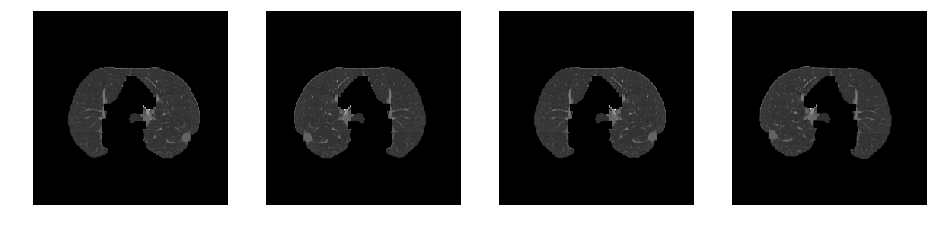

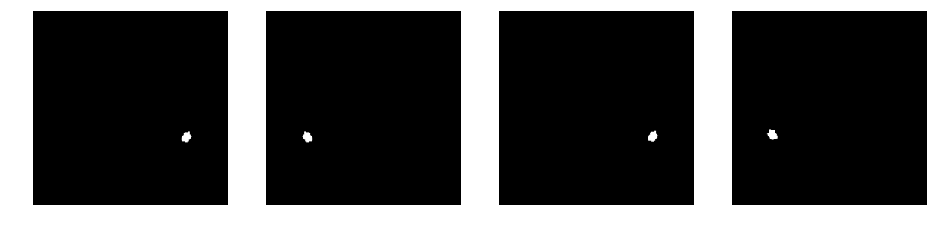

In [5]:
show_augmentation('data/train/image2/1.tif', image_generator_train, n_rows=1)
show_augmentation('data/train/label2/1.tif', label_generator_train, n_rows=1)

## Instantiate and Train the U-Net

In [6]:
# model = unet3d()
model = unet3d_res()
model.compile(
    optimizer = Adam(lr=5e-5),
    loss=weighted_cross_entropy,
#     loss=dice_coef_weighted_loss,
    metrics = [
        'accuracy',
        dice_coef,
        jaccard_distance,
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.SpecificityAtSensitivity(.5),
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=1, save_best_only=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
targets is deprecated, use labels instead


In [7]:
model.fit_generator(
    train_generator,
    steps_per_epoch = 500,
    epochs = 20,
    callbacks=[model_checkpoint]
)

Found 439 images belonging to 1 classes.
Found 439 images belonging to 1 classes.
Found 439 images belonging to 1 classes.
Found 439 images belonging to 1 classes.
Found 439 images belonging to 1 classes.
Found 439 images belonging to 1 classes.
Found 439 images belonging to 1 classes.
Found 439 images belonging to 1 classes.
Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
499/500 [============================>.] - ETA: 0s - loss: 0.0118 - acc: 0.9985 - dice_coef: 0.0070 - jaccard_distance: 75.1298 - precision: 0.2402 - recall: 0.1715 - specificity_at_sensitivity: 0.9944
Epoch 00001: loss improved from inf to 0.01182, saving model to unet_lidc.hdf5
500/500 [==============================] - 216s 431ms/step - loss: 0.0118 - acc: 0.9985 - dice_coef: 0.0070 - jaccard_distance: 75.0863 - precision: 0.2402 - recall: 0.1715 - specificity_at_sensitivity: 0.9944
Epoch 2/20
499/500 [============================>.] - ETA: 0s - loss: 0.0074

499/500 [============================>.] - ETA: 0s - loss: 0.0045 - acc: 0.9990 - dice_coef: 0.0148 - jaccard_distance: 56.4268 - precision: 0.9028 - recall: 0.6236 - specificity_at_sensitivity: 1.0000
Epoch 00016: loss did not improve from 0.00403
500/500 [==============================] - 194s 388ms/step - loss: 0.0045 - acc: 0.9990 - dice_coef: 0.0148 - jaccard_distance: 56.3575 - precision: 0.9028 - recall: 0.6235 - specificity_at_sensitivity: 1.0000
Epoch 17/20
499/500 [============================>.] - ETA: 0s - loss: 0.0037 - acc: 0.9990 - dice_coef: 0.0153 - jaccard_distance: 55.3572 - precision: 0.9005 - recall: 0.6282 - specificity_at_sensitivity: 1.0000
Epoch 00017: loss improved from 0.00403 to 0.00371, saving model to unet_lidc.hdf5
500/500 [==============================] - 195s 390ms/step - loss: 0.0037 - acc: 0.9990 - dice_coef: 0.0152 - jaccard_distance: 55.3703 - precision: 0.9005 - recall: 0.6279 - specificity_at_sensitivity: 1.0000
Epoch 18/20
499/500 [=============

In [8]:
model.save('unet_lidc.hdf5') 

In [9]:
model.load_weights('unet_lidc.hdf5')

## Test the U-Net

### Training set predictions

295


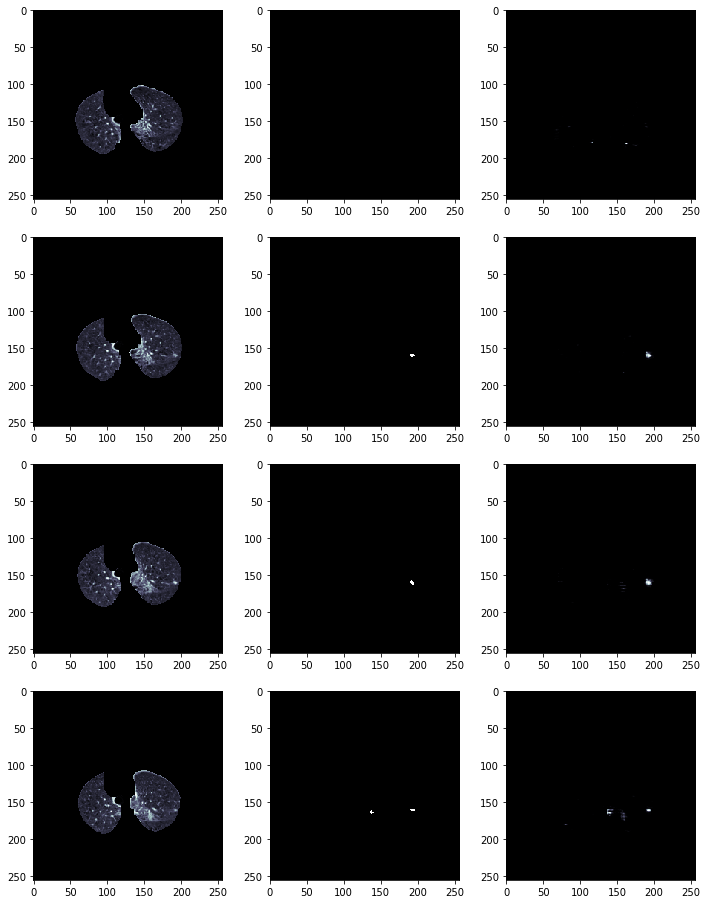

In [10]:
# results = model.predict(X_test, 2, verbose=1)

idx = np.random.randint(len(os.listdir('data/train/image0')))
print(idx)

x0 = np.array(io.imread(f'data/train/image0/{idx}.tif', as_gray=True))/255
x1 = np.array(io.imread(f'data/train/image1/{idx}.tif', as_gray=True))/255
x2 = np.array(io.imread(f'data/train/image2/{idx}.tif', as_gray=True))/255
x3 = np.array(io.imread(f'data/train/image3/{idx}.tif', as_gray=True))/255

X = np.array([x0, x1, x2, x3])

y0 = np.array(io.imread(f'data/train/label0/{idx}.tif', as_gray=True))
y1 = np.array(io.imread(f'data/train/label1/{idx}.tif', as_gray=True))
y2 = np.array(io.imread(f'data/train/label2/{idx}.tif', as_gray=True))
y3 = np.array(io.imread(f'data/train/label3/{idx}.tif', as_gray=True))

Y = np.array([y0, y1, y2, y3])

Y_hat = model.predict(X.reshape(1, 256, 256, 4, 1))

#Plot
fig, axs = plt.subplots(4, 3, figsize=(12, 16))

for i in range(4):
    axs[i][0].imshow(X[i], cmap='bone')
    axs[i][1].imshow(Y[i], cmap='bone')
    axs[i][2].imshow(Y_hat.reshape(4, 256, 256)[i], cmap='bone')

plt.show()

### Test set predictions

75


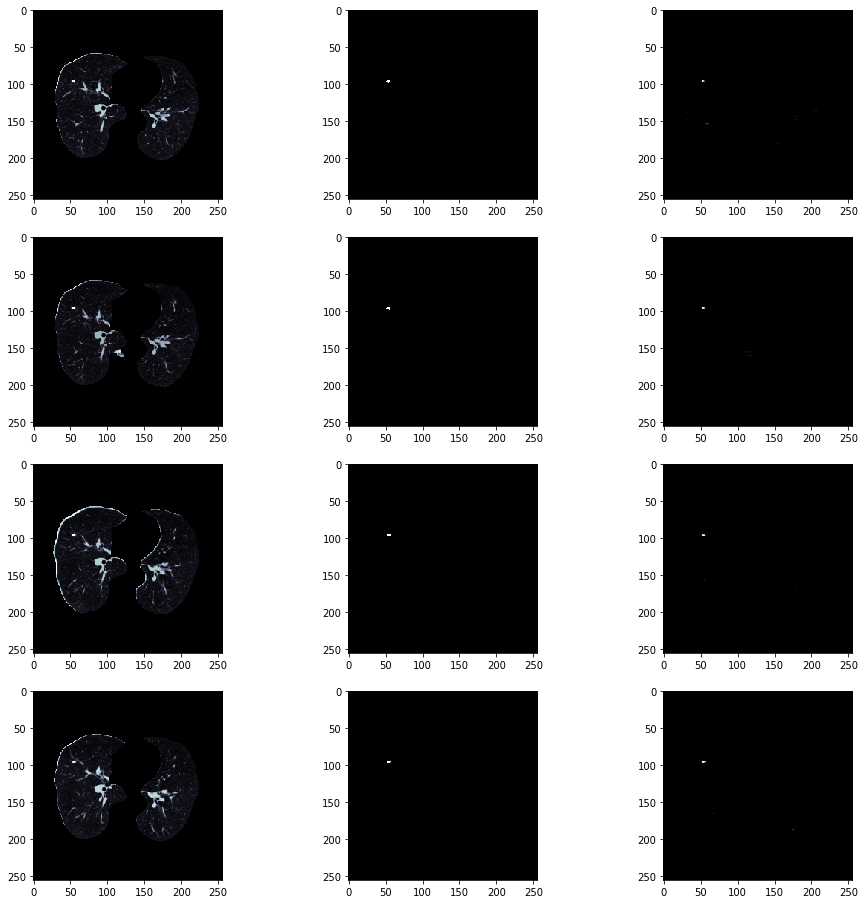

In [12]:
# results = model.predict(X_test, 2, verbose=1)
idx = np.random.randint(len(os.listdir('data/test/image3')))
print(idx)


x0 = np.array(io.imread(f'data/test/image0/{idx}.tif', as_gray=True))/255
x1 = np.array(io.imread(f'data/test/image1/{idx}.tif', as_gray=True))/255
x2 = np.array(io.imread(f'data/test/image2/{idx}.tif', as_gray=True))/255
x3 = np.array(io.imread(f'data/test/image3/{idx}.tif', as_gray=True))/255

X = np.array([x0, x1, x2, x3])

y0 = np.array(io.imread(f'data/test/label0/{idx}.tif', as_gray=True))
y1 = np.array(io.imread(f'data/test/label1/{idx}.tif', as_gray=True))
y2 = np.array(io.imread(f'data/test/label2/{idx}.tif', as_gray=True))
y3 = np.array(io.imread(f'data/test/label3/{idx}.tif', as_gray=True))

Y = np.array([y0, y1, y2, y3])

Y_hat = model.predict(X.reshape(1, 256, 256, 4, 1))

# Plot
fig, axs = plt.subplots(4, 3, figsize=(16, 16))
for i in range(4):
    axs[i][0].imshow(X[i], cmap='bone')
    axs[i][1].imshow(Y[i], cmap='bone')
    axs[i][2].imshow(Y_hat.reshape(4, 256, 256)[i], cmap='bone')

plt.show()